# Improved Dataset with object probabilities, contours, overlap, nms

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import time
import pytorch_lightning as pl
import torchvision
import random
# from scipy.spatial.distance import cdist, directed_hausdorff
from nms import nms
sys.path.append(os.path.join(os.getcwd(), ".."))
#from utils import *
from Models.unet import UNet
from Models.splinedist import *
from utils import *
from Datasets.DSB18 import Nuclie_datamodule
import tqdm
%load_ext autoreload
%autoreload 2

In [6]:
# intialize the dataloaders
datamodule = Nuclie_datamodule(path=os.path.join(os.getcwd(), "..", "Datasets", "DSB18", "train"))
train_loader = datamodule.train_dataloader()
# batch = next(iter(train_loader))

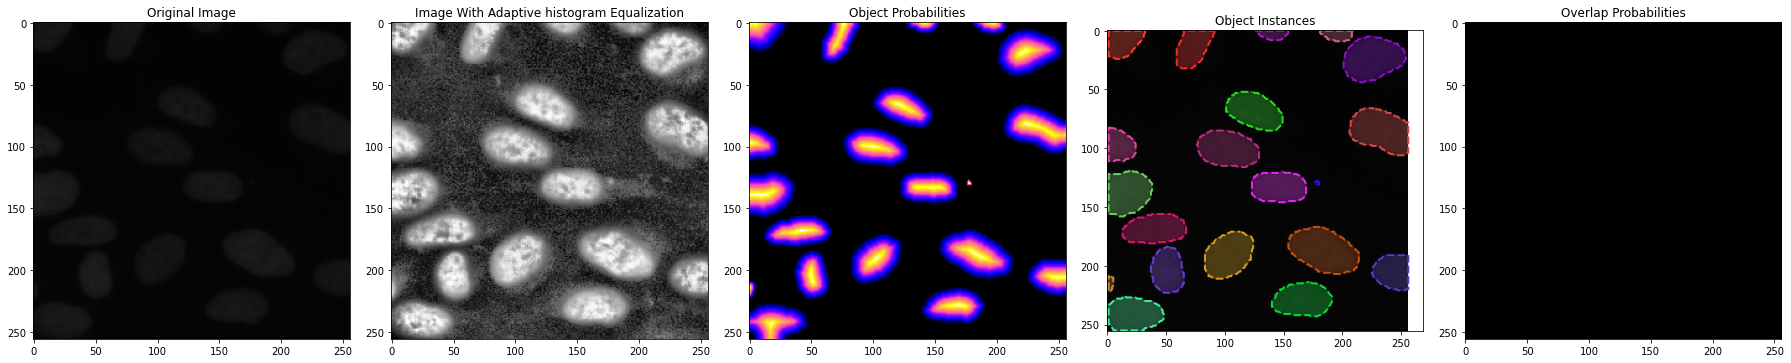

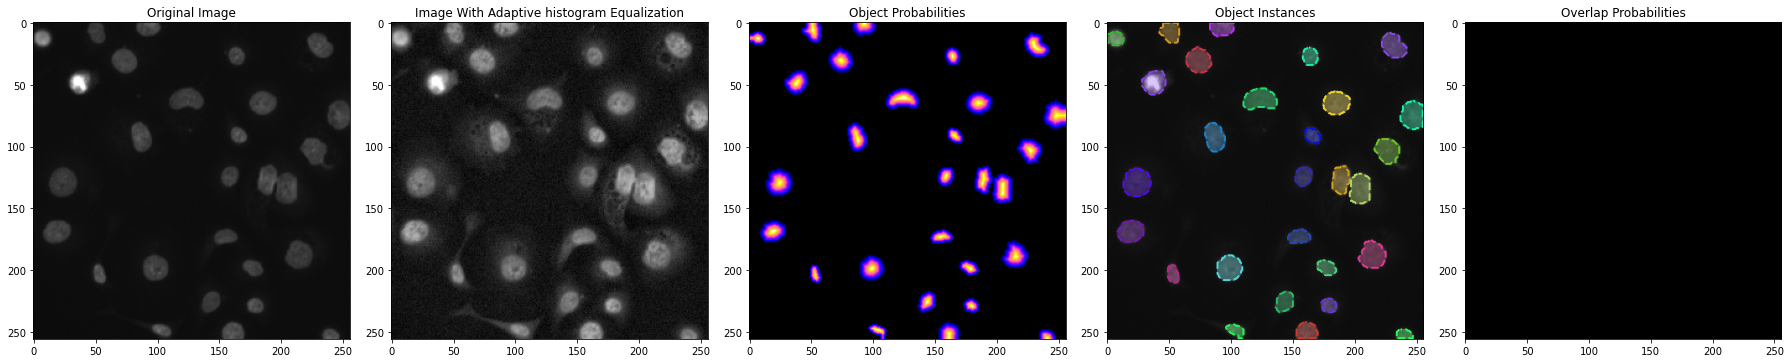

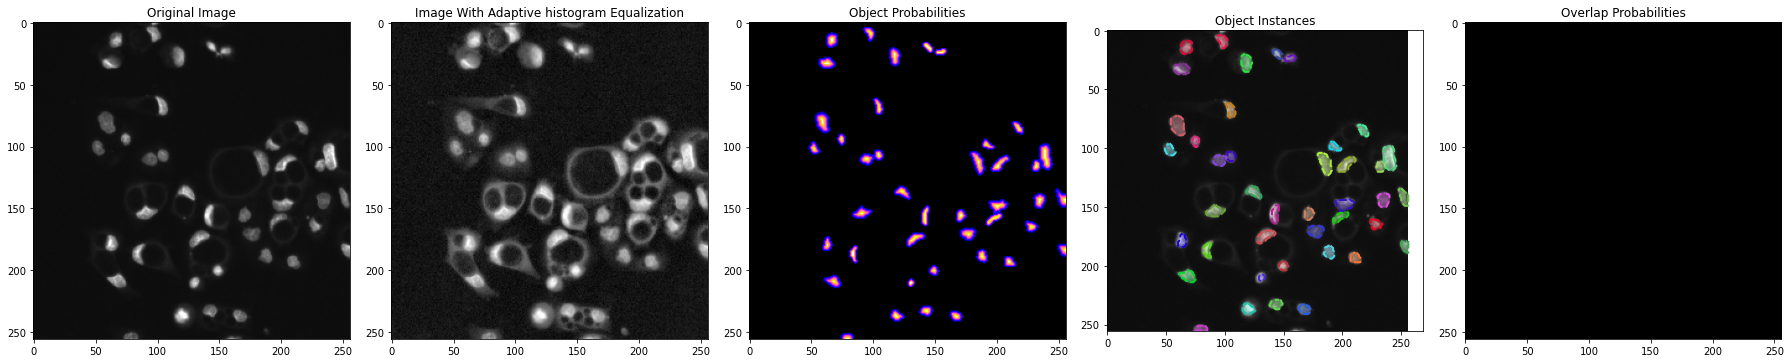

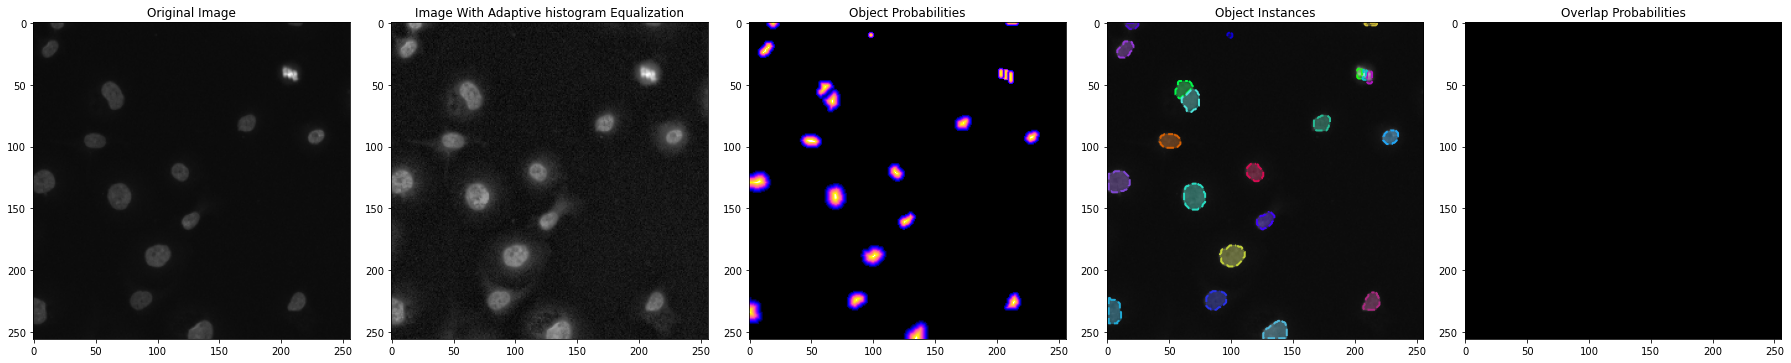

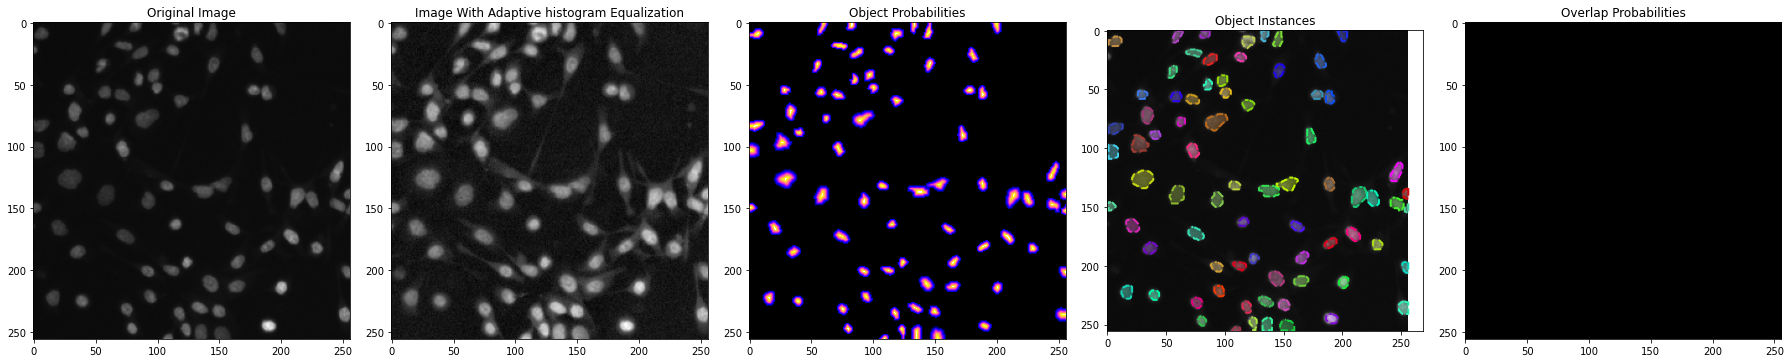

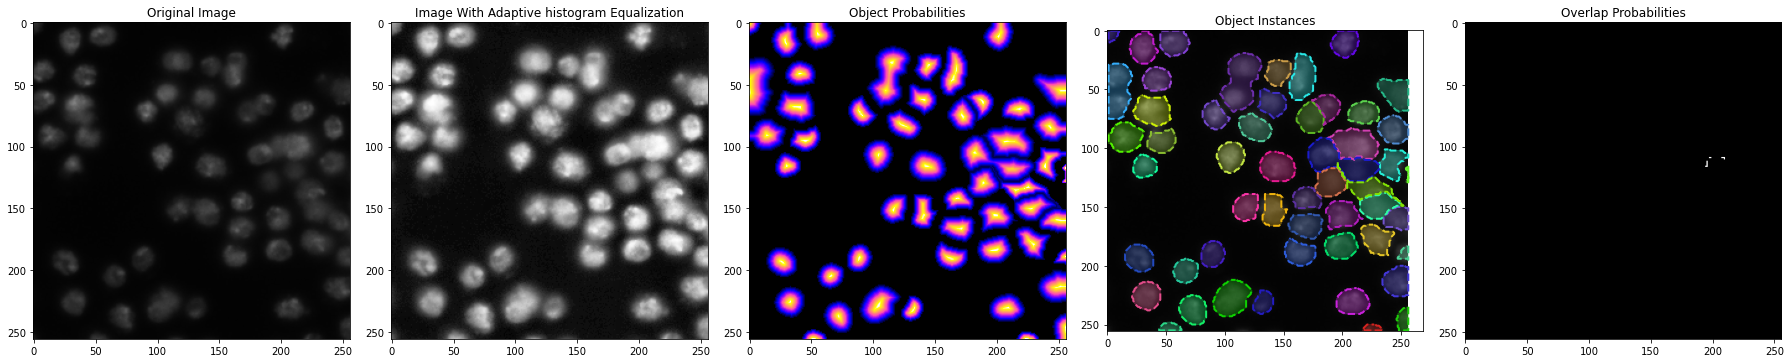

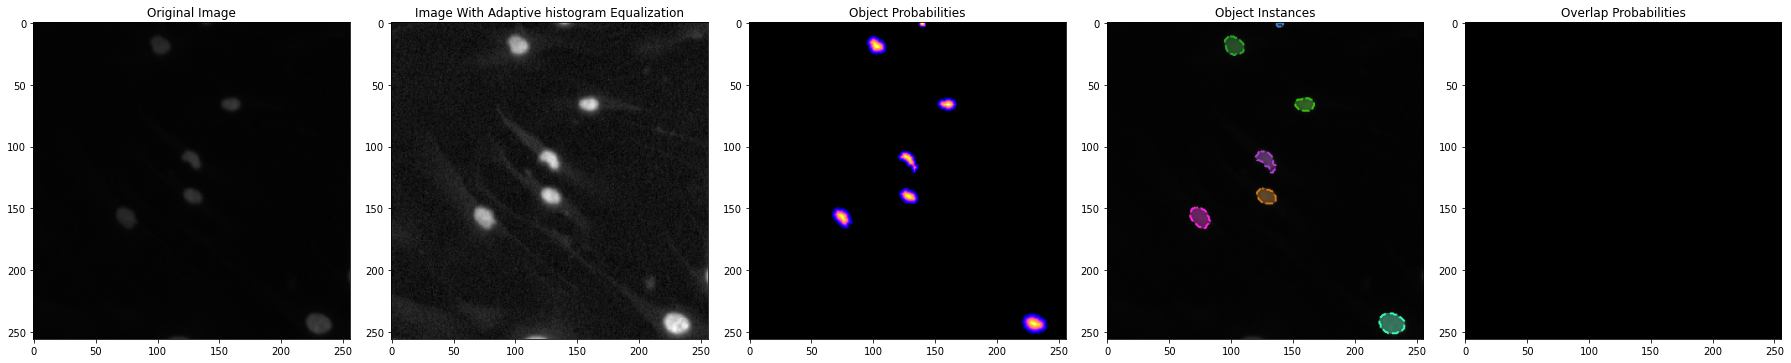

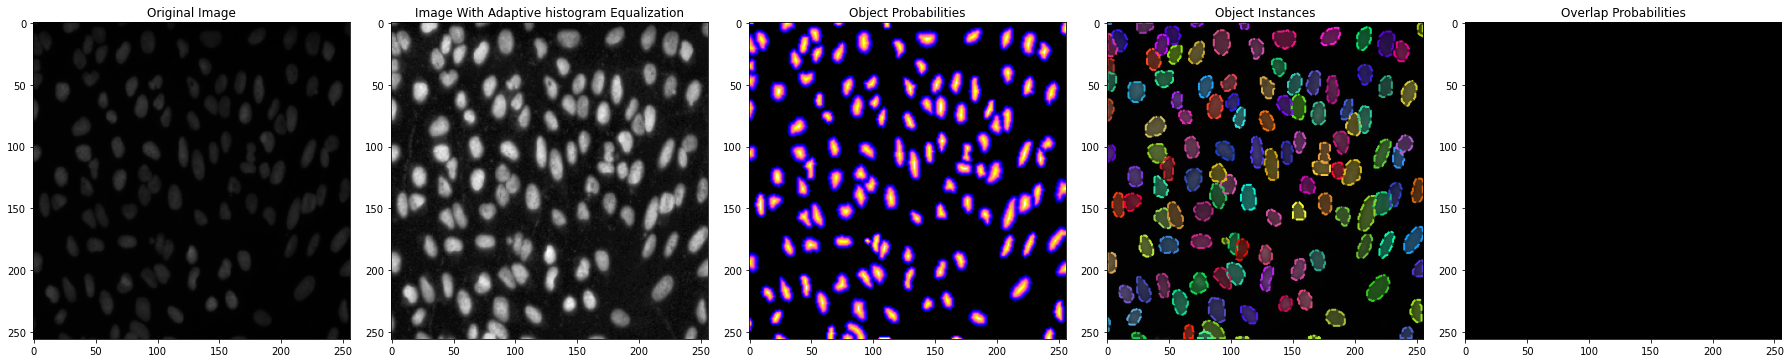

In [3]:
# for i, batch in enumerate(train_loader):
#     if i>2:
#         break
#     showBatch(batch)
batch = next(iter(train_loader))
showBatch(batch)

In [5]:
model = SplineDist()
out = model(batch[0])
objectProbasPredicted, angles, distances = out

In [9]:

objectProbas, overlapProba, objectContours, mask = batch[1][3].values()
scores = objectProbas.numpy()
threshold=0.4
# get index of the sorted scores 
# sortedInstances = list(scores.argsort()[::-1])
sortedInstances = np.unravel_index(np.argsort(scores, axis=None)[::-1], scores.shape)
sortedInstances = list(zip(*sortedInstances))
print(len(sortedInstances))
for i, (instance_i, instance_j) in enumerate(sortedInstances):
    if scores[instance_i, instance_j] < threshold:
        sortedInstances = sortedInstances[:i]
        break
print(len(sortedInstances))


65536
1529


In [10]:
scores.shape

(256, 256)

In [12]:

keep = []
B3M = getBsplineMatrix(numSamples=1000, degree=3, numControlPoints=8).float()
controlPoints = convertOutputsToControlPoints(angles, distances)


In [13]:
controlPoints.dtype, B3M.dtype

(torch.float32, torch.float32)

In [14]:

#samples = getContourSamples(controlPoints[0], B3M)
# contours = getContourSamples(controlPoints, B3M)
# contours = [getContourSamples(controlPoints[i], B3M) for (i, j) in sortedInstances[:10]]
contours = getContourSamples(controlPoints[0].unsqueeze_(0), B3M).squeeze(1)
contours2 = contours.detach().cpu().numpy().reshape(1000, 2, -1).transpose(2, 0, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [00:51<00:00, 1261.45it/s]


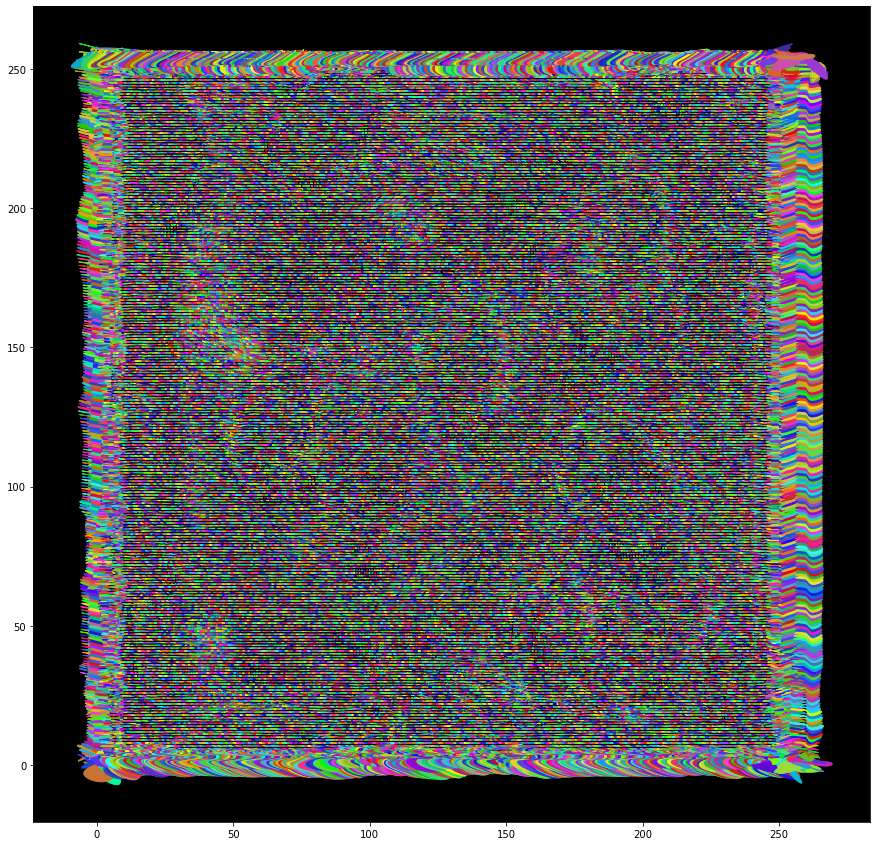

In [15]:
# contours = np.array(list(map(lambda x: np.array(x), contours)))
# contours = contours.transpose(0, 2, 1)
# contours[0]
#colors = generateColors(len(contours2))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_facecolor("black")
for i in tqdm.tqdm(range(len(contours2))):
    c = list(map(lambda x: x/255, getRandomColor()))
    plt.fill(contours2[i, :, 0], contours2[i, :, 1], color=c)

In [16]:
x, y = list(zip(*sortedInstances))
x, y = np.array(x), np.array(y)

In [17]:
contours3 = contours2[x*256+y]
len(contours3)

1529

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1529/1529 [00:02<00:00, 622.56it/s]


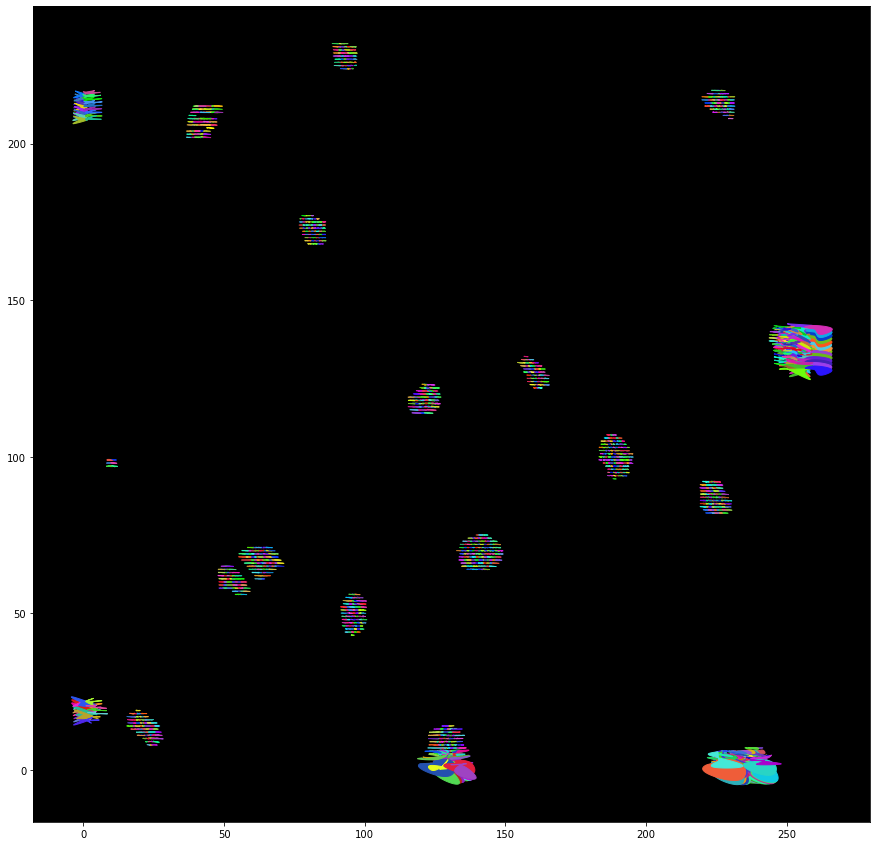

In [18]:

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_facecolor("black")
for i in tqdm.tqdm(range(len(contours3))):
    c = list(map(lambda x: x/255, getRandomColor()))
    plt.fill(contours3[i, :, 0], contours3[i, :, 1], color=c)

In [19]:
ids = nms.nms.polygons(contours2[x*256+y], scores.reshape(-1)[x*256+y])

C:\Users\mbenimam\anaconda3\lib\site-packages\nms\malisiewicz.py:99: RuntimeWarning: invalid value encountered in double_scalars
  overlap.append(intersection_area/area[i])
C:\Users\mbenimam\anaconda3\lib\site-packages\nms\malisiewicz.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  overlap.append(intersection_area/area[i])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 1045.17it/s]


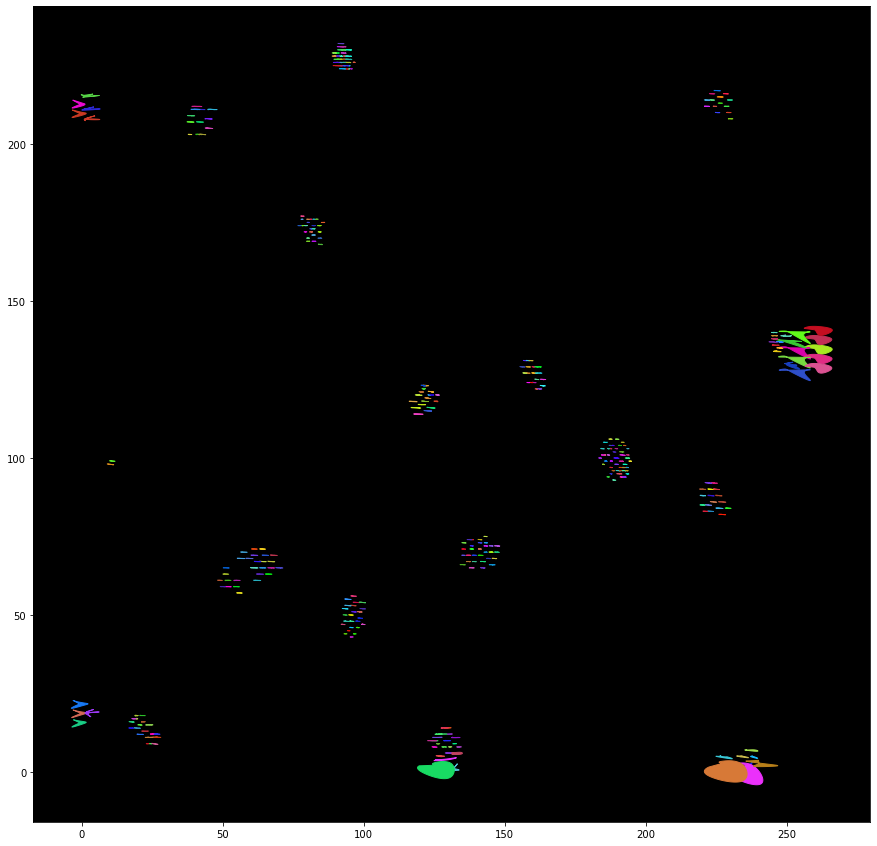

In [20]:
contours4 = contours3[ids]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_facecolor("black")
for i in tqdm.tqdm(range(len(contours4))):
    c = list(map(lambda x: x/255, getRandomColor()))
    plt.fill(contours4[i, :, 0], contours4[i, :, 1], color=c)

In [7]:
from torchvision.utils import make_grid
# grid = make_grid(denormalize(batch_x)).numpy().transpose(1, 2, 0)

In [9]:
batches = []
i = 0
for batch in train_loader:
    
    if i == 5:
        break
    batches.append(batch[0])
    i = i+1

Traceback (most recent call last):


In [10]:
b = torch.cat(batches)

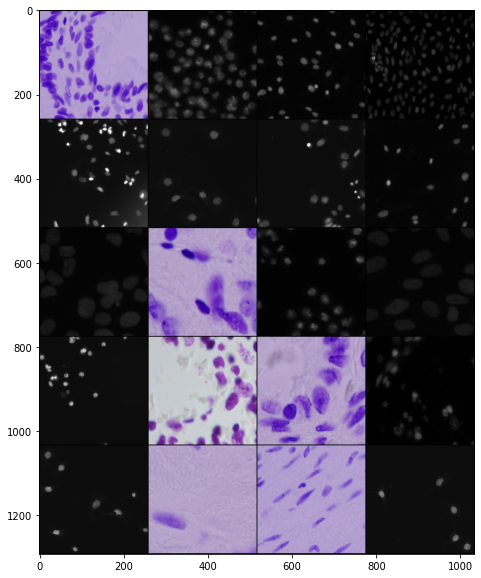

In [11]:
grid = make_grid(denormalize(b), 4).numpy().transpose(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)